In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from itertools import repeat
df = pd.read_csv("CombinedSequences_ppr.csv")

In [2]:
seq = df['Sequence'].to_numpy()
#Function to strip each sequence into k-mers
def kmerise(line,k):  # String and k are inputs
    kmerised_array = []; # Final kmerised list
    for i in line:
        temp = []
        for j in range(0,len(i),k): 
            temp.append(i[j:j+k]) #append substring in each iter 
        kmerised_array.append(temp)
    
    return kmerised_array

In [3]:
df['AccessionID'] = pd.factorize(df['AccessionID'])[0]
df.head()

,AccessionID,Sequence
0,0,ATGAGAGTTCAAAGACCACCCACTCTCTTGTTAGTGTTCTCACTCT...
1,0,ATGATACACTCAGTGTTTCTACTGATGTTCTTGTTAACACCTACAG...
2,0,TATGCCTAACATGTGTAGGATTTTCGCGTCTCTGATTTTGGCACGC...
3,0,TATGCCTAACATGTGTAGGATTTTTGCATCTCTGATTTTGGCACGC...
4,0,TATGCCTAACATGTGTAGGATTTTCGCGTCTCTGATTTTGGCACGC...


In [4]:
df.tail()

,AccessionID,Sequence
2519,2,GACTAAAGATAAAAATTATATACGTATAATTTTTGTCTCTCTAGCT...
2520,2,GACAAAGGTGAAAATTAATATATATATATTAATTTTACTCCTCCTC...
2521,2,GTCATTTGGTAAAATATAATATATATTTTATCACTCTAGCTTCGCT...
2522,2,GACAAAGCTCAAAAATATATATATATATTTTTGTTGCTCCTAGCTT...
2523,2,GACTAAAGATAAAAATTATAGCATTAGTCTATAATTTTATCTCCCT...


In [5]:
kmers_list =  kmerise(seq,15)

In [6]:
baseDict = {'A': 1, 'C': 2, 'G': 3, 'T': 4, 'R': 5, 'Y': 6, 'S': 7, 'W': 8, 'K': 9, 'M': 10, 'B': 11, 'D': 12, 'H': 13, 'V': 14,'N': 15}
# Dictionary to convert each base to corr. number

In [7]:
#Function to convert each k-mer in list to vectors 
def vectorizedList(line):  # String and k are inputs
    vectorized_array = []; # Final vectorised list
    for i in line:
        temp = ""
        for j in range(len(i)):
            temp += str(baseDict[i[j]])
        vectorized_array.append(int(temp))
    
    return vectorized_array

In [8]:
Vec = []
len_vec = []
for i in range(len(kmers_list)):
    Vec.append(vectorizedList(kmers_list[i]))
    len_vec.append(len(kmers_list[i]))
#Vec

In [9]:
f = [[float(i) for i in j] for j in Vec]
Vec = [[i / sum(j) for i in j] for j in f]

In [10]:
#Padding with extra zeros to match length of all sequences
def padding(seq, len_vec):
    anotherseq = seq.copy()
    max_kmerlen = max(len_vec)
    for i in anotherseq:
        diff = max_kmerlen - len(i)
        i.extend(repeat(0, diff))
    
    return anotherseq    

In [11]:
pad = padding(Vec, len_vec)

In [12]:
from keras.models import Model ,Sequential
from keras.layers import Input, Dropout, Flatten, Dense, Activation
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score,roc_curve
import keras 

In [13]:
X = np.asarray(pad)#.astype(np.float32)
y = df['AccessionID'].to_numpy()#.astype(np.float32)

In [14]:
x_train, x_test, y_train, Y_test = train_test_split(X, y, test_size=0.33)

In [15]:
x_train = x_train.astype('float32') 
x_test = x_test.astype('float32') 

In [16]:
# Converting into one-hot encoded format
fields = len(np.unique(df['AccessionID']))
from keras.utils.np_utils import to_categorical
#For training data
y_train = np.uint8(to_categorical(y_train, num_classes = fields))

#For test data
y_test = np.uint8(to_categorical(Y_test, num_classes = fields))

In [17]:
x_train

array([[0.04372344, 0.07441494, 0.07820745, ..., 0.        , 0.        ,
        0.        ],
       [0.04424227, 0.03109292, 0.05433986, ..., 0.        , 0.        ,
        0.        ],
       [0.0090762 , 0.01013899, 0.03439976, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.0021217 , 0.00652944, 0.00183608, ..., 0.        , 0.        ,
        0.        ],
       [0.09748992, 0.09979343, 0.0276199 , ..., 0.        , 0.        ,
        0.        ],
       [0.03677528, 0.0125312 , 0.03748517, ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [18]:
print(x_train.shape)
print(x_test.shape)

(1691, 2118)
(833, 2118)


In [19]:
print(y_train.shape)
print(y_test.shape)

(1691, 3)
(833, 3)


In [20]:
y_train

array([[0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       ...,
       [0, 1, 0],
       [1, 0, 0],
       [1, 0, 0]], dtype=uint8)

In [21]:
model = Sequential()

model.add(Dense(32, input_dim = (x_train.shape[1]), activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(fields, activation='softmax'))

In [22]:
model.compile(optimizer="ADAM", loss="categorical_crossentropy" ,metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                67808     
_________________________________________________________________
dense_1 (Dense)              (None, 512)               16896     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 195       
Total params: 117,731
Trainable params: 117,731
Non-trainable params: 0
_________________________________________________________________


In [23]:
model.fit(x_train, y_train, epochs = 40, verbose = 1)

Epoch 1/40
53/53 [==============================] - 1s 2ms/step - loss: 0.9036 - accuracy: 0.6645
Epoch 2/40
53/53 [==============================] - 0s 2ms/step - loss: 0.5757 - accuracy: 0.6958
Epoch 3/40
53/53 [==============================] - 0s 2ms/step - loss: 0.4780 - accuracy: 0.8224
Epoch 4/40
53/53 [==============================] - 0s 2ms/step - loss: 0.3915 - accuracy: 0.8464
Epoch 5/40
53/53 [==============================] - 0s 2ms/step - loss: 0.3724 - accuracy: 0.8395
Epoch 6/40
53/53 [==============================] - 0s 2ms/step - loss: 0.3335 - accuracy: 0.8650
Epoch 7/40
53/53 [==============================] - 0s 2ms/step - loss: 0.3049 - accuracy: 0.8701
Epoch 8/40
53/53 [==============================] - 0s 2ms/step - loss: 0.2809 - accuracy: 0.8720
Epoch 9/40
53/53 [==============================] - 0s 2ms/step - loss: 0.3012 - accuracy: 0.8765
Epoch 10/40
53/53 [==============================] - 0s 2ms/step - loss: 0.2703 - accuracy: 0.8927
Epoch 11/40
53/53 [

In [24]:
#Printing the loss and accuracy of training and testing sets
loss, accuracy = model.evaluate(x_train, y_train, verbose=1)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
print("Testing Accuracy:  {:.4f}".format(accuracy))
print("\nFinal Loss = ",loss)

53/53 [==============================] - 0s 1ms/step - loss: 0.1579 - accuracy: 0.9533
Training Accuracy: 0.9533
27/27 [==============================] - 0s 1ms/step - loss: 0.3321 - accuracy: 0.9016
Testing Accuracy:  0.9016

Final Loss =  0.3321060240268707


#### 10 fold Cross Validation for relu architecture 

In [25]:
from sklearn.model_selection import StratifiedKFold

In [26]:
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=123)
cvscores = []
for train, test in kfold.split(X, y):
    model = Sequential()
    model.add(Dense(32, input_dim = (x_train.shape[1]), activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(fields, activation='softmax'))
    model.compile(optimizer = "adam", loss = "mean_squared_error", metrics = "accuracy")
    model.fit(x_train, y_train, epochs = 32,verbose = 0)
    scores = model.evaluate(x_test, y_test, verbose = 0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)

accuracy: 89.92%
accuracy: 89.56%
accuracy: 88.24%
accuracy: 90.64%
accuracy: 89.20%
accuracy: 90.52%
accuracy: 90.52%
accuracy: 90.16%
accuracy: 89.20%
accuracy: 90.40%


In [27]:
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

89.83% (+/- 0.74%)


In [28]:
y_pred = model.predict(x_test)
Y_pred_classes = np.argmax(y_pred,axis=1)
y_act = np.argmax(y_test,axis=1)

In [29]:
conf_matrix = np.zeros((fields,fields))
for i in range(len(y_act)):
    conf_matrix[Y_pred_classes[i]][y_act[i]] += 1

In [30]:
conf_matrix

array([[220.,  23.,   0.],
       [ 57., 522.,   0.],
       [  0.,   0.,  11.]])

In [31]:
precision = precision_score(Y_test, Y_pred_classes, average='macro')
recall = recall_score(Y_test, Y_pred_classes, average='macro')
f1score = f1_score(Y_test, Y_pred_classes, average='macro')
print("Precision: ", precision)
print("Recall: ", recall)
print("F1-score: ", f1score)

Precision:  0.935634732794587
Recall:  0.9173406639508054
F1-score:  0.9249931563098822


In [32]:
#roc auc score
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.metrics import roc_curve, auc
roc_auc_score(y_test, y_pred, multi_class='ovo', average='weighted')

0.913880645183733

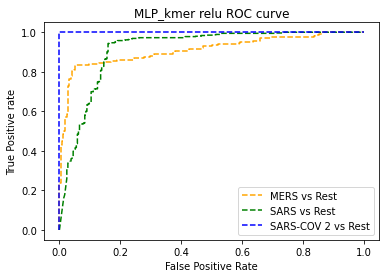

In [33]:
from sklearn.metrics import roc_curve, auc
# roc curve for classes
fpr = {}
tpr = {}
roc_auc ={}

for i in range(fields):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='MERS vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='SARS vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='SARS-COV 2 vs Rest')
plt.title('MLP_kmer relu ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.show()

### Sigmoid Activation

In [34]:
model = Sequential()

model.add(Dense(32, input_dim = (x_train.shape[1]), activation='sigmoid'))
model.add(Dense(512, activation='sigmoid'))
model.add(Dense(64, activation='sigmoid'))
model.add(Dense(fields, activation='softmax'))

In [35]:
model.compile(optimizer="ADAM", loss="categorical_crossentropy" ,metrics = ['accuracy'])
model.fit(x_train, y_train, epochs = 40, verbose = 1)

Epoch 1/40
53/53 [==============================] - 1s 2ms/step - loss: 0.7612 - accuracy: 0.6312
Epoch 2/40
53/53 [==============================] - 0s 2ms/step - loss: 0.6798 - accuracy: 0.6808
Epoch 3/40
53/53 [==============================] - 0s 2ms/step - loss: 0.6913 - accuracy: 0.6612
Epoch 4/40
53/53 [==============================] - 0s 2ms/step - loss: 0.6818 - accuracy: 0.6741
Epoch 5/40
53/53 [==============================] - 0s 2ms/step - loss: 0.6815 - accuracy: 0.6892
Epoch 6/40
53/53 [==============================] - 0s 2ms/step - loss: 0.6772 - accuracy: 0.6788
Epoch 7/40
53/53 [==============================] - 0s 2ms/step - loss: 0.6794 - accuracy: 0.6696
Epoch 8/40
53/53 [==============================] - 0s 2ms/step - loss: 0.6745 - accuracy: 0.6757
Epoch 9/40
53/53 [==============================] - 0s 2ms/step - loss: 0.6618 - accuracy: 0.6817
Epoch 10/40
53/53 [==============================] - 0s 2ms/step - loss: 0.6671 - accuracy: 0.6866
Epoch 11/40
53/53 [

In [36]:
#Printing the loss and accuracy of training and testing sets
loss, accuracy = model.evaluate(x_train, y_train, verbose=1)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
print("Testing Accuracy:  {:.4f}".format(accuracy))
print("\nFinal Loss = ",loss)

53/53 [==============================] - 0s 1ms/step - loss: 0.3217 - accuracy: 0.8770
Training Accuracy: 0.8770
27/27 [==============================] - 0s 1ms/step - loss: 0.3829 - accuracy: 0.8487
Testing Accuracy:  0.8487

Final Loss =  0.38286086916923523


In [37]:
y_pred = model.predict(x_test)
Y_pred_classes = np.argmax(y_pred,axis=1)
y_act = np.argmax(y_test,axis=1)

In [38]:
conf_matrix = np.zeros((fields,fields))
for i in range(len(y_act)):
    conf_matrix[Y_pred_classes[i]][y_act[i]] += 1
conf_matrix

array([[188.,  37.,   0.],
       [ 88., 508.,   0.],
       [  1.,   0.,  11.]])

In [39]:
precision = precision_score(Y_test, Y_pred_classes, average='macro')
recall = recall_score(Y_test, Y_pred_classes, average='macro')
f1score = f1_score(Y_test, Y_pred_classes, average='macro')
print("Precision: ", precision)
print("Recall: ", recall)
print("F1-score: ", f1score)

Precision:  0.8681904051702709
Recall:  0.8702701509179832
F1-score:  0.8653242331769088


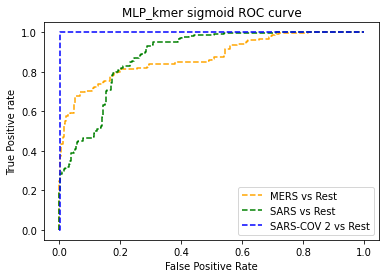

In [40]:
roc_auc_score(y_test, y_pred, multi_class='ovo', average='weighted')

# roc curve for classes
fpr = {}
tpr = {}
roc_auc ={}

for i in range(fields):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='MERS vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='SARS vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='SARS-COV 2 vs Rest')
plt.title('MLP_kmer sigmoid ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.show()

### tanh Activation

In [41]:
model = Sequential()

model.add(Dense(32, input_dim = (x_train.shape[1]), activation='sigmoid'))
model.add(Dense(512, activation='sigmoid'))
model.add(Dense(64, activation='sigmoid'))
model.add(Dense(fields, activation='softmax'))

In [42]:
model.compile(optimizer="adam", loss="categorical_crossentropy" ,metrics = ['accuracy'])
model.fit(x_train, y_train, epochs = 40, verbose = 1)

Epoch 1/40
53/53 [==============================] - 1s 2ms/step - loss: 0.7336 - accuracy: 0.6864
Epoch 2/40
53/53 [==============================] - 0s 2ms/step - loss: 0.6728 - accuracy: 0.7017
Epoch 3/40
53/53 [==============================] - 0s 2ms/step - loss: 0.6680 - accuracy: 0.6834
Epoch 4/40
53/53 [==============================] - 0s 2ms/step - loss: 0.6795 - accuracy: 0.6614
Epoch 5/40
53/53 [==============================] - 0s 2ms/step - loss: 0.6700 - accuracy: 0.6837: 0s - loss: 0.6642 - accuracy: 0.68
Epoch 6/40
53/53 [==============================] - 0s 2ms/step - loss: 0.7053 - accuracy: 0.6543
Epoch 7/40
53/53 [==============================] - 0s 2ms/step - loss: 0.6711 - accuracy: 0.6636
Epoch 8/40
53/53 [==============================] - 0s 2ms/step - loss: 0.6558 - accuracy: 0.6872
Epoch 9/40
53/53 [==============================] - 0s 2ms/step - loss: 0.6686 - accuracy: 0.6741
Epoch 10/40
53/53 [==============================] - 0s 2ms/step - loss: 0.6643 - 

In [43]:
#Printing the loss and accuracy of training and testing sets
loss, accuracy = model.evaluate(x_train, y_train, verbose=1)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
print("Testing Accuracy:  {:.4f}".format(accuracy))
print("\nFinal Loss = ",loss)

53/53 [==============================] - 0s 1ms/step - loss: 0.3465 - accuracy: 0.8486
Training Accuracy: 0.8486
27/27 [==============================] - 0s 1ms/step - loss: 0.4089 - accuracy: 0.8211
Testing Accuracy:  0.8211

Final Loss =  0.4089203476905823


In [44]:
y_pred = model.predict(x_test)
Y_pred_classes = np.argmax(y_pred,axis=1)
y_act = np.argmax(y_test,axis=1)

In [45]:
conf_matrix = np.zeros((fields,fields))
for i in range(len(y_act)):
    conf_matrix[Y_pred_classes[i]][y_act[i]] += 1
conf_matrix

array([[206.,  78.,   0.],
       [ 70., 467.,   0.],
       [  1.,   0.,  11.]])

In [46]:
precision = precision_score(Y_test, Y_pred_classes, average='macro')
recall = recall_score(Y_test, Y_pred_classes, average='macro')
f1score = f1_score(Y_test, Y_pred_classes, average='macro')
print("Precision: ", precision)
print("Recall: ", recall)
print("F1-score: ", f1score)

Precision:  0.8372216539460225
Recall:  0.8668543481380894
F1-score:  0.8513802857846994


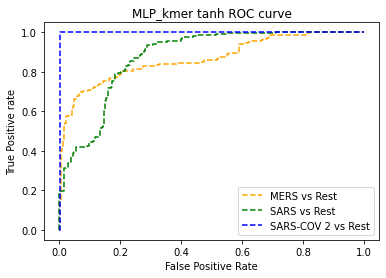

In [47]:
roc_auc_score(y_test, y_pred, multi_class='ovo', average='weighted')

# roc curve for classes
fpr = {}
tpr = {}
roc_auc ={}

for i in range(fields):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='MERS vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='SARS vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='SARS-COV 2 vs Rest')
plt.title('MLP_kmer tanh ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.show()

### elu activation

In [48]:
model = Sequential()

model.add(Dense(32, input_dim = (x_train.shape[1]), activation='elu'))
model.add(Dense(512, activation='elu'))
model.add(Dense(64, activation='elu'))
model.add(Dense(fields, activation='softmax'))

In [49]:
model.compile(optimizer="adagrad", loss="mean_squared_error" ,metrics = ['accuracy'])
model.fit(x_train, y_train, epochs = 20, verbose = 1)

Epoch 1/20
53/53 [==============================] - 1s 2ms/step - loss: 0.2186 - accuracy: 0.6439
Epoch 2/20
53/53 [==============================] - 0s 2ms/step - loss: 0.2083 - accuracy: 0.6542
Epoch 3/20
53/53 [==============================] - 0s 2ms/step - loss: 0.2000 - accuracy: 0.6652
Epoch 4/20
53/53 [==============================] - 0s 2ms/step - loss: 0.1937 - accuracy: 0.6581
Epoch 5/20
53/53 [==============================] - 0s 2ms/step - loss: 0.1879 - accuracy: 0.6664
Epoch 6/20
53/53 [==============================] - 0s 2ms/step - loss: 0.1815 - accuracy: 0.6809
Epoch 7/20
53/53 [==============================] - 0s 2ms/step - loss: 0.1794 - accuracy: 0.6648
Epoch 8/20
53/53 [==============================] - 0s 2ms/step - loss: 0.1728 - accuracy: 0.6912
Epoch 9/20
53/53 [==============================] - 0s 2ms/step - loss: 0.1707 - accuracy: 0.6868
Epoch 10/20
53/53 [==============================] - 0s 2ms/step - loss: 0.1681 - accuracy: 0.6858
Epoch 11/20
53/53 [

In [50]:
#Printing the loss and accuracy of training and testing sets
loss, accuracy = model.evaluate(x_train, y_train, verbose=1)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
print("Testing Accuracy:  {:.4f}".format(accuracy))
print("\nFinal Loss = ",loss)

53/53 [==============================] - 0s 1ms/step - loss: 0.1568 - accuracy: 0.6777
Training Accuracy: 0.6777
27/27 [==============================] - 0s 1ms/step - loss: 0.1623 - accuracy: 0.6543
Testing Accuracy:  0.6543

Final Loss =  0.16231419146060944


In [51]:
y_pred = model.predict(x_test)
Y_pred_classes = np.argmax(y_pred,axis=1)
y_act = np.argmax(y_test,axis=1)

In [52]:
conf_matrix = np.zeros((fields,fields))
for i in range(len(y_act)):
    conf_matrix[Y_pred_classes[i]][y_act[i]] += 1
conf_matrix

array([[  0.,   0.,   0.],
       [277., 545.,  11.],
       [  0.,   0.,   0.]])

In [53]:
precision = precision_score(Y_test, Y_pred_classes, average='macro')
recall = recall_score(Y_test, Y_pred_classes, average='macro')
f1score = f1_score(Y_test, Y_pred_classes, average='macro')
print("Precision: ", precision)
print("Recall: ", recall)
print("F1-score: ", f1score)

Precision:  0.21808723489395757
Recall:  0.3333333333333333
F1-score:  0.26366715045960326


C:\Users\ARRUN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


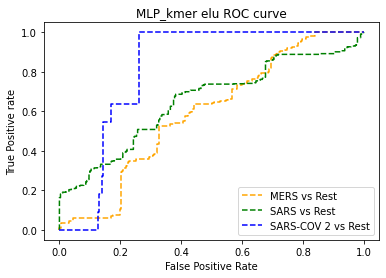

In [54]:
roc_auc_score(y_test, y_pred, multi_class='ovo', average='weighted')

# roc curve for classes
fpr = {}
tpr = {}
roc_auc ={}

for i in range(fields):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='MERS vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='SARS vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='SARS-COV 2 vs Rest')
plt.title('MLP_kmer elu ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.show()

### selu Activation

In [55]:
model = Sequential()

model.add(Dense(32, input_dim = (x_train.shape[1]), activation='selu'))
model.add(Dense(512, activation='selu'))
model.add(Dense(64, activation='selu'))
model.add(Dense(fields, activation='softmax'))

In [56]:
model.compile(optimizer="adagrad", loss="mean_squared_error" ,metrics = ['accuracy'])
model.fit(x_train, y_train, epochs = 20, verbose = 1)

Epoch 1/20
53/53 [==============================] - 1s 2ms/step - loss: 0.2120 - accuracy: 0.6573
Epoch 2/20
53/53 [==============================] - 0s 2ms/step - loss: 0.1864 - accuracy: 0.6813
Epoch 3/20
53/53 [==============================] - 0s 2ms/step - loss: 0.1741 - accuracy: 0.6720
Epoch 4/20
53/53 [==============================] - 0s 2ms/step - loss: 0.1629 - accuracy: 0.6961
Epoch 5/20
53/53 [==============================] - 0s 2ms/step - loss: 0.1600 - accuracy: 0.6871
Epoch 6/20
53/53 [==============================] - 0s 2ms/step - loss: 0.1612 - accuracy: 0.6689
Epoch 7/20
53/53 [==============================] - 0s 2ms/step - loss: 0.1551 - accuracy: 0.6887
Epoch 8/20
53/53 [==============================] - 0s 2ms/step - loss: 0.1575 - accuracy: 0.6729
Epoch 9/20
53/53 [==============================] - 0s 2ms/step - loss: 0.1563 - accuracy: 0.6744
Epoch 10/20
53/53 [==============================] - 0s 2ms/step - loss: 0.1535 - accuracy: 0.6815
Epoch 11/20
53/53 [

In [57]:
#Printing the loss and accuracy of training and testing sets
loss, accuracy = model.evaluate(x_train, y_train, verbose=1)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
print("Testing Accuracy:  {:.4f}".format(accuracy))
print("\nFinal Loss = ",loss)

53/53 [==============================] - 0s 1ms/step - loss: 0.1498 - accuracy: 0.6777
Training Accuracy: 0.6777
27/27 [==============================] - 0s 1ms/step - loss: 0.1561 - accuracy: 0.6543
Testing Accuracy:  0.6543

Final Loss =  0.15614764392375946


In [58]:
y_pred = model.predict(x_test)
Y_pred_classes = np.argmax(y_pred,axis=1)
y_act = np.argmax(y_test,axis=1)

In [59]:
conf_matrix = np.zeros((fields,fields))
for i in range(len(y_act)):
    conf_matrix[Y_pred_classes[i]][y_act[i]] += 1
conf_matrix

array([[  0.,   0.,   0.],
       [277., 545.,  11.],
       [  0.,   0.,   0.]])

In [60]:
precision = precision_score(Y_test, Y_pred_classes, average='macro')
recall = recall_score(Y_test, Y_pred_classes, average='macro')
f1score = f1_score(Y_test, Y_pred_classes, average='macro')
print("Precision: ", precision)
print("Recall: ", recall)
print("F1-score: ", f1score)

Precision:  0.21808723489395757
Recall:  0.3333333333333333
F1-score:  0.26366715045960326


C:\Users\ARRUN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


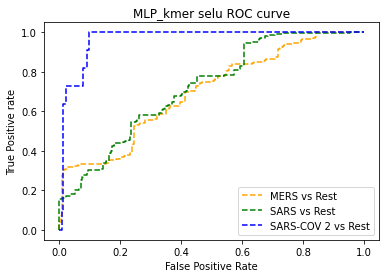

In [61]:
roc_auc_score(y_test, y_pred, multi_class='ovo', average='weighted')

# roc curve for classes
fpr = {}
tpr = {}
roc_auc ={}

for i in range(fields):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='MERS vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='SARS vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='SARS-COV 2 vs Rest')
plt.title('MLP_kmer selu ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.show()